Nama: Annaura Zyra Alifa W
---
NIM: 2602205540
---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/Dataset2B-20240427T185501Z-001/Dataset2B'

# **1.Eksplorasi data dan resize gambar menjadi 224 x 224**

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [3]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


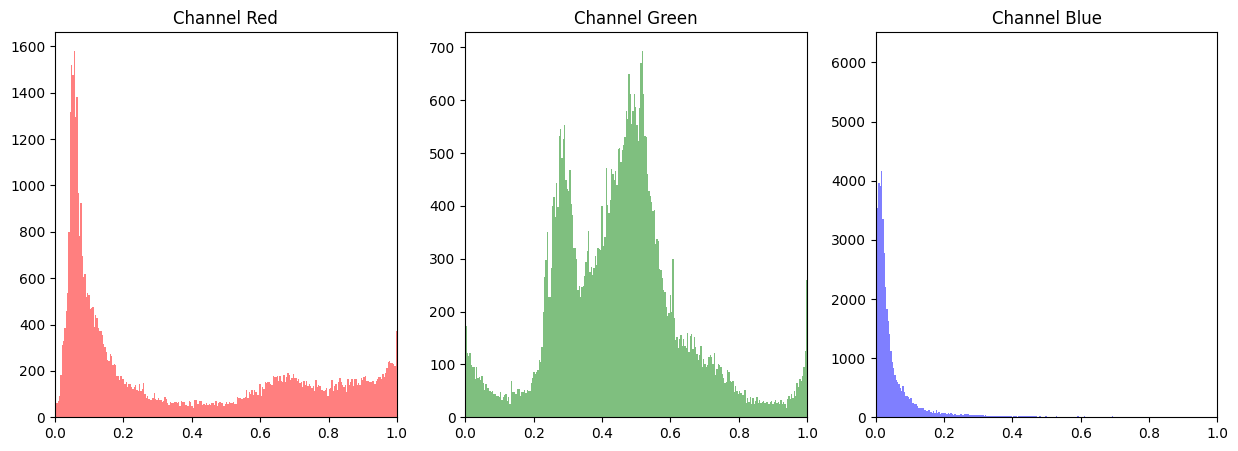

In [4]:
x_batch, y_batch = next(train_generator)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].hist(x_batch[0,:,:,i].ravel(), bins=256, color=('r' if i == 0 else 'g' if i == 1 else 'b'), alpha=0.5)
    ax[i].set_title(f'Channel {["Red","Green","Blue"][i]}')
    ax[i].set_xlim([0,1])
plt.show()

### 2. **Kualitas Gambar**
Terdapat gambar dengan resolusi rendah yang mungkin kekruangan detail tekstur. terdapat juga noise pada gambar yang membuat fotonya menjadi blurry dan dapat mengganggu pendeteksian. berikut adalah contoh gambarnya (gambar '0.jpg')
  

### 2. **Variabilitas Gambar**
   - Terdapat gambar yang diambil dari sudut yang tidak baik bisa membingungkan model karena perubahan dalam orientasi atau bentuk yang terlihat dari objek. Contohnya adalah buah blacberry yang ada pada gambar '47.jpg'
   - Terdapat Objek yang terhalang oleh elemen lain (seperti pohon atau orang lain) bisa menghambat identifikasi yang tepat.
   - Terdapat latar belakang yang memiliki warna atau tekstur yang mirip. contohnya ada pada image '210.jpg'
   - Muncul Objek yang sama dalam berbagai ukuran atau jarak dalam gambar berbeda dapat membuat model yang tidak dilatih sulit untuk  mengenali variasi tersebut. Contohnya ada pada gambar '26.jpg'

01.jpg

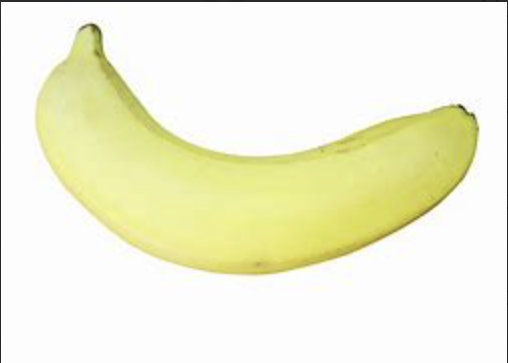

47.jpg

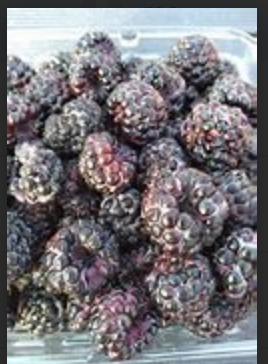

210.jpg

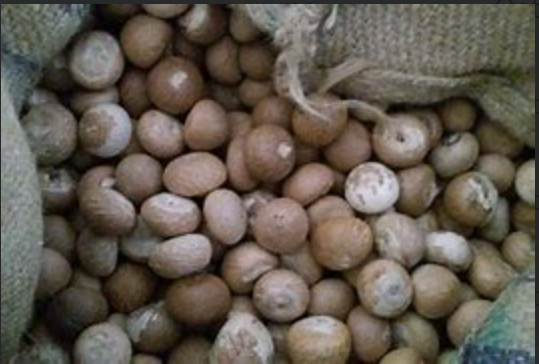

'26.jpg'

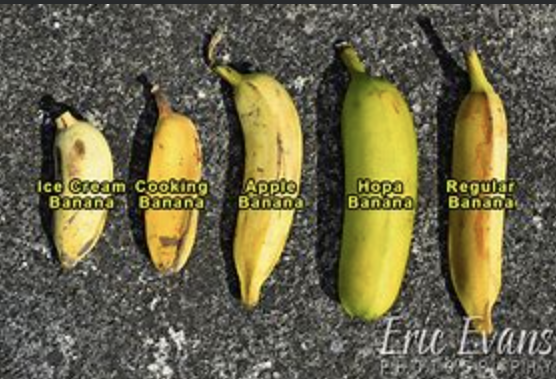

# **3. Arsitektur Baseline**

Model VGG-16 yang digunakan adalah versi pretrained dengan bobot dari dataset ImageNet dan telah diajarkan untuk mengidentifikasi berbagai kelas objek. Dalam proses fine-tuning, lapisan atas dari model pretrained ini tidak diikutsertakan (include_top=False), hal ini memungkinkan untuk menyesuaikan model dengan output yang lebih spesifik untuk dataset yang memiliki empat kelas. Setelah menambahkan lapisan Flatten dan Dense baru, Dropout digunakan untuk mengurangi overfitting, yang mendorong model untuk mempelajari representasi yang lebih kuat dan menguramngi ketergantungan pada fitur tertentu. Lapisan prediksi terakhir menggunakan fungsi aktivasi softmax untuk klasifikasi empat kelas. Lapisan dari model VGG-16 asli dibekukan untuk mempertahankan fitur yang telah dipelajari, sementara lapisan yang ditambahkan dilatih pada data baru. Model ini dikompilasi dengan optimizer 'adam' dan fungsi loss 'categorical_crossentropy'.

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    # Blok pertama
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Blok kedua
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Blok ketiga
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Blok keempat
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Blok kelima
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Lapisan sepenuhnya terhubung
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1000, activation='softmax')
])


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


58889256/58889256 [==============================] - 0s 0us/step


In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **4. Modifikasi Arsitektur**

Modifikasi pada arsitektur VGG16 (penambahan BatchNormalization dan Dropout) bertujuan untuk meningkatkan kinerja model untuk menghadapi tantangan kualitas gambar dan variabilitas dalam dataset. BatchNormalization sangat berguna untuk dataset dengan kualitas gambar yang bervariasi dan agar pelatihan  lebih stabil. Dropout mengurangi overfitting dengan memaksa model untuk tidak terlalu bergantung pada fitur spesifik mana pun, hal ini membantu model bekerja  lebih baik terhadap noise dan perubahan dalam orientasi objek atau latar belakang. Penggunaan optimizer Adam dengan learning rate rendah membantu dalam penyesuaian terhadap bobot untuk data yang kompleks. Keseluruhan pendekatan ini menghasilkan model yang lebih tahan terhadap ketidaksempurnaan data dan mampu memprediksi dengan lebih akurat.

In [9]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
custom_predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=custom_predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **5. Evaluasi**
Dari matriks, kita dapat melihat bahwa model telah melakukan klasifikasi dengan tingkat akurasi yang sangat tinggi. Untuk kelas pisang, bitter gourd, dan blackberry, model telah mencapai akurasi sempurna dengan tidak ada kesalahan klasifikasi, yang ditunjukkan oleh 80 prediksi yang benar untuk masing-masing kelas dan nol kesalahan. Namun, untuk betel nut, terdapat kesalahan klasifikasi, salah mengklasifikasikannya sebagai bitter gourd. Tidak ada kesalahan lain yang terdeteksi antar kelas lainnya. Secara keseluruhan, hasil ini menunjukkan bahwa model memiliki kemampuan diskriminatif yang sangat baik untuk tiga dari empat kelas, dengan sedikit ketidaktelitian antara bitter gourd dan betel nut. Dalam konteks nyata, ini bisa menandakan bahwa fitur-fitur visual dari bitter gourd dan betel nut mungkin memiliki kesamaan yang cukup mirip.

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test loss: {:.2f}".format(test_loss))

steps = test_generator.samples // test_generator.batch_size + (test_generator.samples % test_generator.batch_size > 0)
predictions = model.predict(test_generator, steps=steps)

if hasattr(predictions, 'numpy'):
    predictions = predictions.numpy()

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

10/10 [==============================] - 207s 21s/step - loss: 1.4563 - accuracy: 0.2250
Test accuracy: 22.50%
Test loss: 1.46
10/10 [==============================] - 214s 21s/step


In [12]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      banana       0.27      0.76      0.40        80
   betel_nut       0.36      0.05      0.09        80
bitter_gourd       0.27      0.26      0.26        80
 black_berry       0.50      0.01      0.02        80

    accuracy                           0.27       320
   macro avg       0.35      0.27      0.19       320
weighted avg       0.35      0.27      0.19       320



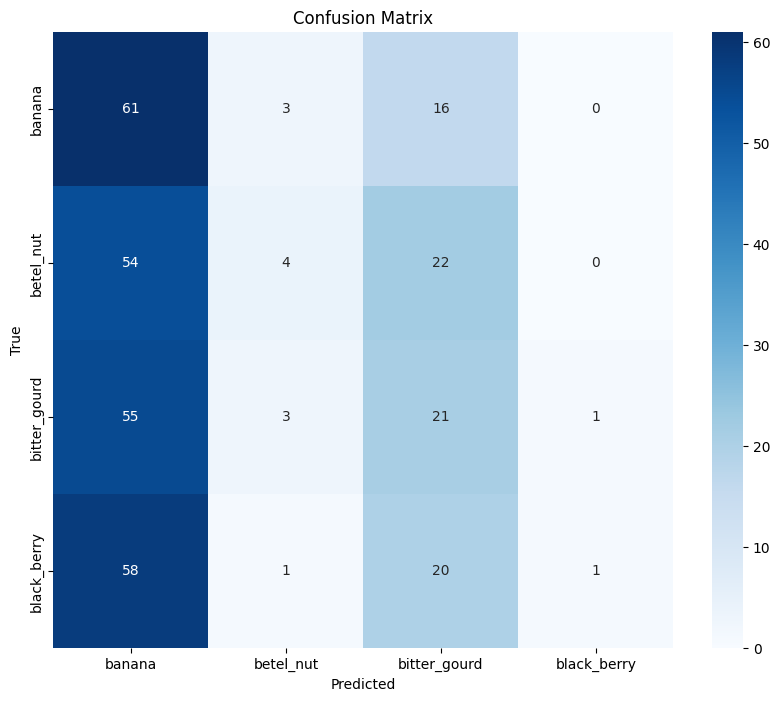

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
